<a href="https://colab.research.google.com/github/datbibip/ThucHanh1/blob/master/ThucHanh2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/time_series/ecg_sample_data.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(5)

,Time (s),ECG (mV)
0,0.000,0.053489
1,0.004,0.005731
2,0.008,0.092026
3,0.012,0.096355
4,0.016,0.229249


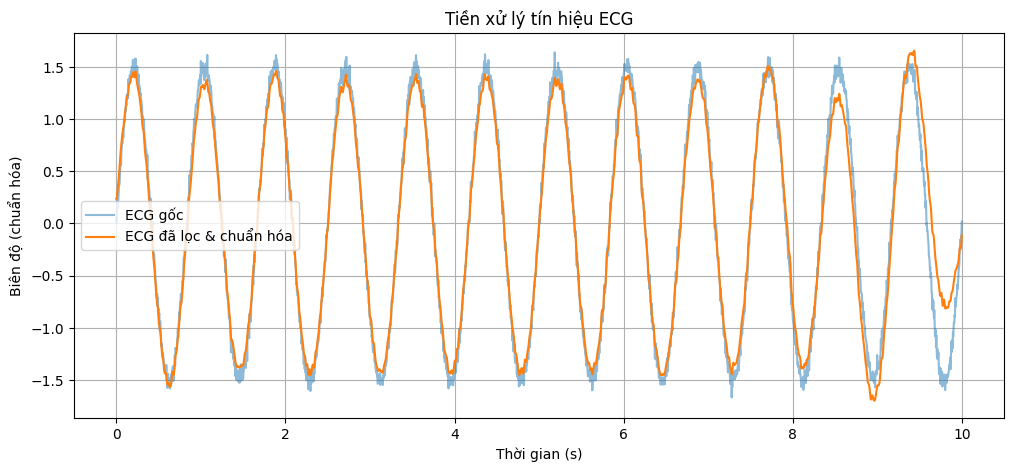

In [ ]:
from scipy.signal import butter, filtfilt
# === 2. Lấy tín hiệu ECG và thời gian ===
ecg_signal = df['ECG (mV)'].values
time = df['Time (s)'].values

# === 3. Ước lượng tần số lấy mẫu (fs) từ thời gian ===
# Giả sử thời gian lấy mẫu đều: fs = 1 / (khoảng thời gian giữa 2 mẫu)
fs = 1 / np.mean(np.diff(time))  # ví dụ: 250 Hz nếu mỗi mẫu cách 0.004s

# === 4. Bandpass Filter loại nhiễu ===
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=250.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_ecg = bandpass_filter(ecg_signal, fs=fs)

# === 5. Chuẩn hóa tín hiệu ===
normalized_ecg = (filtered_ecg - np.mean(filtered_ecg)) / np.std(filtered_ecg)

# === 6. Hiển thị kết quả ===
plt.figure(figsize=(12, 5))
plt.plot(time, ecg_signal, label='ECG gốc', alpha=0.5)
plt.plot(time, normalized_ecg, label='ECG đã lọc & chuẩn hóa', linewidth=1.5)
plt.xlabel("Thời gian (s)")
plt.ylabel("Biên độ (chuẩn hóa)")
plt.title("Tiền xử lý tín hiệu ECG")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pip install hmmlearn filterpy


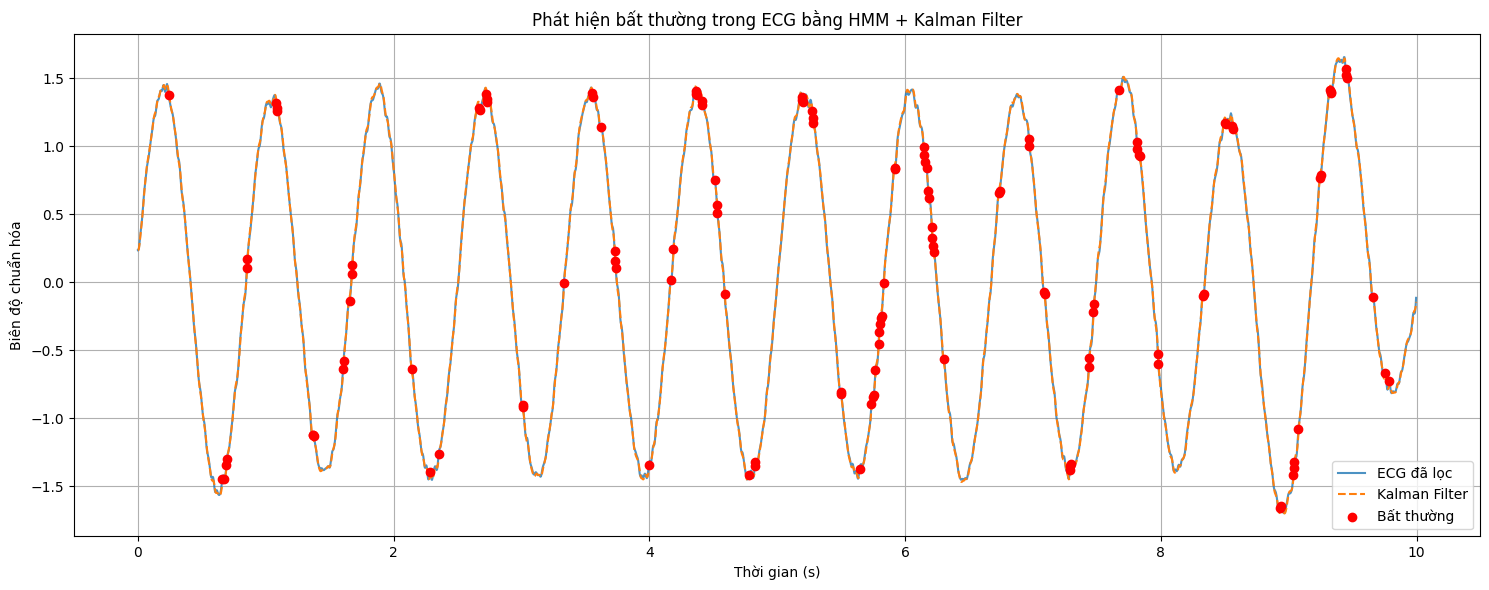

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from hmmlearn.hmm import GaussianHMM
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

ecg_signal = df['ECG (mV)'].values
time = df['Time (s)'].values

# Ước lượng tần số lấy mẫu
fs = 1 / np.mean(np.diff(time))

# === 2. Lọc nhiễu với bandpass filter ===
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_ecg = bandpass_filter(ecg_signal, fs=fs)

# === 3. Chuẩn hóa tín hiệu ===
normalized_ecg = (filtered_ecg - np.mean(filtered_ecg)) / np.std(filtered_ecg)

# === 4. Huấn luyện HMM với 2 trạng thái ===
X = normalized_ecg.reshape(-1, 1)
model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
model.fit(X)
hidden_states = model.predict(X)

# === 5. Kalman Filter dự đoán tín hiệu ===
def create_kalman_filter():
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = np.array([[1., 1.],
                     [0., 1.]])  # ma trận trạng thái
    kf.H = np.array([[1., 0.]])  # chỉ đo trực tiếp biên độ
    kf.P *= 1000.
    kf.R *= 0.5
    kf.Q *= 0.01
    kf.x = np.array([[0.], [0.]])
    return kf

kf = create_kalman_filter()
filtered = []
residuals = []

for z in normalized_ecg:
    kf.predict()
    kf.update(np.array([[z]]))
    filtered.append(kf.x[0, 0])
    residuals.append(abs(z - kf.x[0, 0]))

# === 6. Phát hiện bất thường dựa trên residuals ===
threshold = np.percentile(residuals, 95)  # ngưỡng: top 5% lệch
anomalies = np.where(np.array(residuals) > threshold)[0]

# === 7. Trực quan hóa kết quả ===
plt.figure(figsize=(15, 6))
plt.plot(time, normalized_ecg, label="ECG đã lọc", alpha=0.8)
plt.plot(time, filtered, label="Kalman Filter", linestyle='--')
plt.scatter(time[anomalies], normalized_ecg[anomalies], color='red', label="Bất thường", zorder=5)
plt.xlabel("Thời gian (s)")
plt.ylabel("Biên độ chuẩn hóa")
plt.title("Phát hiện bất thường trong ECG bằng HMM + Kalman Filter")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import time

# Hàm để tính toán thời gian huấn luyện và dự đoán
def measure_time(model, X):
    start_time = time.time()  # Bắt đầu thời gian
    model.fit(X)  # Huấn luyện mô hình HMM
    end_time = time.time()  # Kết thúc thời gian
    training_time = end_time - start_time  # Thời gian huấn luyện
    print(f"Thời gian huấn luyện HMM: {training_time} giây")

    start_time = time.time()
    hidden_states = model.predict(X)  # Dự đoán trạng thái ẩn
    end_time = time.time()
    prediction_time = end_time - start_time  # Thời gian dự đoán
    print(f"Thời gian dự đoán HMM: {prediction_time} giây")

    # Đo thời gian cho Kalman Filter
    start_time = time.time()
    for z in normalized_ecg:
        kf.predict()
        kf.update(np.array([[z]]))
    end_time = time.time()
    kalman_time = end_time - start_time
    print(f"Thời gian Kalman Filter: {kalman_time} giây")

# Đo thời gian huấn luyện và dự đoán
measure_time(model, X)


Thời gian huấn luyện HMM: 0.046631813049316406 giây
Thời gian dự đoán HMM: 0.0008537769317626953 giây
Thời gian Kalman Filter: 0.09430456161499023 giây


In [ ]:
# Tính Log-Likelihood
log_likelihood = model.score(X)
print(f"Log-Likelihood: {log_likelihood}")


Log-Likelihood: -1608.5532423886377
